In [ ]:
!nvidia-smi

In [57]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

In [58]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [59]:
scipy.__version__

'1.10.1'

In [5]:
weights_path='/M28/Bhumika_Logs_gpu1/nissl20230811T0849/mask_rcnn_nissl_1500.h5'

In [6]:
import os
import numpy as np
from PIL import Image
from math import floor
def tile_image(image,sz=512):
    fileExt='jp2'
    h,w,c=image.shape
    tiles={}
    for row in range(0, h, sz):
        for col in range(0, w, sz):
            tile = image[row:min(row + sz, h), col:min(col + sz, w), :]
#             maskT = mask[row:min(row + sz, w), col:min(col + sz, h)]
            tileName = str(floor(row/sz)+1) + "_" + str(floor(col/sz)+1) + "." + fileExt # fileName w/o fileExtension 
#             print(tileName)
            tiles[tileName]=tile
    return tiles
          
def restitch_tiles(tiles):
    # Extract tile size from the first tile
    first_tile_key = next(iter(tiles))
    first_tile = tiles[first_tile_key]
    tile_size = first_tile.shape[:2]  # Extract height and width dimensions

    # Calculate the dimensions of the original image
    max_row = max_col = 0
    for tile_key in tiles:
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices
        max_row = max(max_row, row)
        max_col = max(max_col, col)
    w = tile_size[1] * max_col
    h = tile_size[0] * max_row

    # Create an empty array for the restitched image
    if len(first_tile.shape)==3:
        restitched_image = np.zeros((h, w, 3), dtype=np.uint8)
    if len(first_tile.shape)==2:
        restitched_image = np.zeros((h, w) , dtype=np.uint8)
    # Iterate over each tile
    for tile_key in tiles:
        tile_array = tiles[tile_key]

        # Extract the tile position from the file name
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices

        # Calculate the pixel coordinates for the tile
        start_row = (row - 1) * tile_size[0]
        end_row = start_row + tile_array.shape[0]
        start_col = (col - 1) * tile_size[1]
        end_col = start_col + tile_array.shape[1]

        # Insert the tile into the restitched image array
        if len(first_tile.shape)==3:
            restitched_image[start_row:end_row, start_col:end_col, :] = tile_array
        if len(first_tile.shape)==2:
            restitched_image[start_row:end_row, start_col:end_col] = tile_array
    # Return the restitched image array
    return restitched_image


In [7]:
from PIL import Image, ImageFile
Image.MAX_IMAGE_PIXELS = 9105779438000


In [ ]:
start_time=time.time()
image=imread('/M28/Bhumika/FB10_WSI/B_118_FB10-SL_176-ST_NISL-SE_526_lossless.tif')
read_end_time=time.time()
read_time=(read_end_time-start_time)
print('Image Reading Time: ',read_time, " seconds.")

In [15]:
print(read_time)

4670.4866371154785


In [14]:
image.shape

(110065, 78104, 3)

In [16]:
H,W,C=image.shape

In [17]:
print(H,W,C)

110065 78104 3


In [24]:
# plt.imshow(image[:,:,:])
# plt.axis('off')  # Optional: Turn off axis labels
# plt.show()

In [18]:
tiling_start=time.time()
Tile_dict=tile_image(image)
tiling_end=time.time()
tiling_time=(tiling_end-tiling_start)
print("Image Tiling time: ",tiling_time, " seconds.")


Image Tiling time:  0.14702415466308594  seconds.


In [19]:
print("Total Number of tiles: ",len(Tile_dict.keys()))

Total Number of tiles:  32895


# Running Inference 

In [20]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.intra_op_parallelism_threads=1
config.inter_op_parallelism_threads=1
set_session(tf.Session(config=config))

2023-09-19 14:19:58.350580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Using TensorFlow backend.
2023-09-19 14:20:00.500536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 2300000000 Hz
2023-09-19 14:20:00.501126: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c7b570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-19 14:20:00.501170: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-19 14:20:00.508852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-19 14:20:00.702709: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xff4130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-19 14:20:00.702789: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-09-19 14:20:00.705235: I tensorflow/core/common_ru

In [21]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np
from mrcnn import model as modellib

In [22]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4,8,16,32,64) #(16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.95

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([110])    #np.array([0, 0, 117])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 500 #500 #710#800 #1000#710 #128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4000

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 4000

class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.99

    USE_MINI_MASK = False

In [23]:
config = NucleusInferenceConfig()
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='/logs')

In [24]:
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 1500


In [25]:
#MASK OVERLAY ON ORIGINAL IMAGE

def get_annotated_cells_img(original_image, annotated_cells):
    # Create a copy of the original image
    display_image = original_image.copy()

    # Iterate over each annotated cell
    for i in range(annotated_cells.shape[2]):
        # Extract the binary annotation for the current cell
        cell_annotation = annotated_cells[:, :, i]

        # Create a boolean mask for the current cell annotation
        cell_mask = np.zeros_like(original_image[:, :, 0])
        cell_mask[cell_annotation > 0] = 255

        # Convert the mask to BGR color space
        cell_mask_bgr = cv2.cvtColor(cell_mask, cv2.COLOR_GRAY2BGR)

        # Set the red channel to maximum intensity (255)
        cell_mask_bgr[:, :, 0][cell_mask == 255] = 255
        cell_mask_bgr[:, :, 1][cell_mask == 255] = 0
        cell_mask_bgr[:, :, 2][cell_mask == 255] = 0
        # Add the cell mask to the display image
        display_image = cv2.add(display_image, cell_mask_bgr)
    return display_image

In [26]:
def combine_out_array(out):
    if out.shape[-1]>0:
        out_combined = out[...,0].astype(np.uint16)
        for x in range(1,out.shape[-1]):
            out_combined += out[...,x].astype(np.uint16)*(x+1) 
        return out_combined
    else: return np.zeros(out.shape[:-1],out.dtype)

In [ ]:
inference_start=time.time()
OUTPUT_TILE_DICT={}

for i,imgfile in enumerate(Tile_dict.keys()):
    img_o = Tile_dict[imgfile]
    image_lab = cv2.cvtColor(img_o, cv2.COLOR_BGR2LAB)
    image_L_inverted = (255-image_lab[:,:,0])
    img_ = cv2.merge((image_L_inverted,image_L_inverted,image_L_inverted))
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    OUTPUT_TILE_DICT[imgfile]=(combine_out_array(out)>0) *1 
inference_end=time.time()

In [28]:
inferencing_time=(inference_end-inference_start)/60
print("Image Inferencing Time: ",inferencing_time," minutes.")

Image Inferencing Time:  1087.470098487536  minutes.


In [29]:
restiching_start=time.time()
stiched_op_img=restitch_tiles(OUTPUT_TILE_DICT)
restiching_end=time.time()
stitching_time=restiching_end-restiching_start
print(stiched_op_img.shape)
print("Image restitching time: ",stitching_time, " seconds.")

(110080, 78336)
Image restitching time:  28.571749448776245  seconds.


In [30]:
# import numpy as np
# import tifffile

# Assuming you have an image array (numpy array) named 'image_array'

# Specify the file path and name for the output TIFF file
saving_start=time.time()
# output_file = "/M28/mba_converted_imaging_data/MD806/Hippocampus_inference_data/bin_mask_1150_1500th_wt.tif"
output_file= "/M28/Bhumika/FB10_WSI/B_118_FB10-SL_176-ST_NISL-SE_526_lossless_bin_mask.png"
# Write the image array as a TIFF file
# imsave(output_file, stiched_op_img[:H,:W,:]) #for 3 channel image
imsave(output_file, stiched_op_img[:H,:W]) #for binary image
saving_end=time.time()
saving_time=(saving_end-saving_start)/60
print("TIF file saved successfully.")
print("Image Saving time: ",saving_time," minutes.")

/tmp/ipykernel_20643/1117476683.py:12: UserWarning: /M28/Bhumika/FB10_WSI/B_118_FB10-SL_176-ST_NISL-SE_526_lossless_bin_mask.png is a low contrast image
  imsave(output_file, stiched_op_img[:H,:W]) #for binary image


TIF file saved successfully.
Image Saving time:  7.010956446329753  minutes.


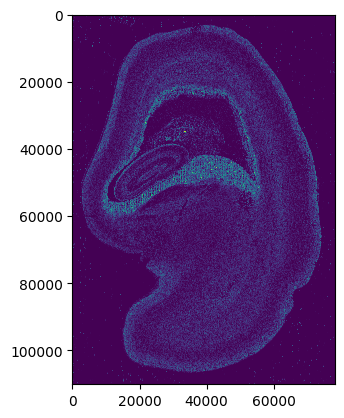

In [48]:
plt.imshow(imread(output_file)[:,:,...])

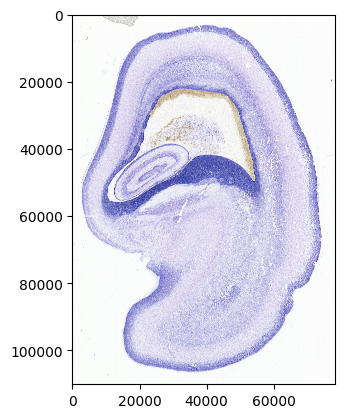

In [49]:
plt.imshow(image)

In [73]:
# image.shape

(55040, 113280, 3)

In [31]:
print("Total Running time of this ipynb (Reading, Saving and viewing the inferenced image) is: ",(saving_end-start_time)/60, " minutes.")

Total Running time of this ipynb (Reading, Saving and viewing the inferenced image) is:  1177.9190246740977  minutes.


In [32]:
print("Total Image processing Time: ", read_time+inferencing_time+(stitching_time/60)+saving_time," minutes.")




Total Image processing Time:  5765.443887873491  minutes.


In [44]:
# H

In [113]:
# W

107520

In [39]:
import matplotlib.pyplot as plt

def show_images_side_by_side(image1, image2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Plot the first image
    ax[0].imshow(image1)
    ax[0].axis('off')

    # Plot the second image
    ax[1].imshow(image2,cmap='gray')
    ax[1].axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1)

    # Display the figure
    plt.savefig('/M28/Bhumika/FB10_WSI/sample_tiles/'+img_name+'.jpg')
    plt.show()
def overlay_binary_mask_on_original_image(binmask,bgimage,color):
# Create a mask from image1 where bright pixels are white (255) and dark pixels are black (0)
    mask = (binmask > 0).astype(np.uint8) * 255
#     print(mask.shape)
    # Convert the mask to a 3-channel image to match the shape of image2
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Create a yellow color mask with the same size as image2
    if color=='green':
        mask_color = np.full_like(bgimage, (0, 255, 0), dtype=np.uint8)
    if color=='red':
        mask_color = np.full_like(bgimage, (255, 0, 0), dtype=np.uint8)
    if color=='orange':
        mask_color = np.full_like(bgimage, (255, 20, 0), dtype=np.uint8)
    if color=='pink':
        mask_color = np.full_like(bgimage,(255,0,255), dtype=np.uint8) 

    colored_mask = cv2.bitwise_and(mask_color, mask_color, mask=mask)
    result = cv2.addWeighted(bgimage, 1, colored_mask, 1, 0)
    return result

In [54]:
img_name='100_90'

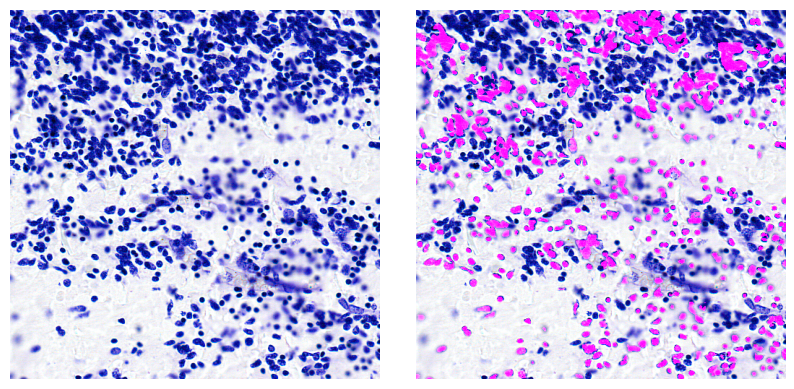

In [55]:
show_images_side_by_side(Tile_dict[img_name+'.jp2'],overlay_binary_mask_on_original_image(OUTPUT_TILE_DICT[img_name+'.jp2'],Tile_dict[img_name+'.jp2'],'pink'))

In [ ]:
# plt.imshow()